In [1]:
import ROOT as root
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

Welcome to JupyROOT 6.24/06


In [2]:
thisParticle = 22
thisMass = 0.0
Analyse_Secondaries = 1
Theta_min_cut = 0.0 

MaxHits = 50000
MaxPMTNo = 20
MaxPMTHits = 5000
Finger_Edep_Max = 10.0
AnaBar_Edep_Max = 10.0
pedastel_sigma = 2.9
Detector_Offset = 0

Finger_NPhotons_Max = 250
AnaBar_NPhotons_Max = 200

NUMPADDLE = 14

NMaxPMT = 14

Detector_pdg = np.array([0 for i in range(MaxHits)],dtype=int)
Detector_id = np.array([0 for i in range(MaxHits)],dtype=int)

Detector_x = np.array([0 for i in range(MaxHits)],dtype=float)
Detector_y = np.array([0 for i in range(MaxHits)],dtype=float)
Detector_z = np.array([0 for i in range(MaxHits)],dtype=float)
Detector_t = np.array([0 for i in range(MaxHits)],dtype=float)
Detector_Ed = np.array([0 for i in range(MaxHits)],dtype=float)

PMT_Nphotons = np.array([0 for i in range(MaxPMTNo)],dtype=int)
PMT_Nphotons_Noise = np.array([0 for i in range(MaxPMTNo)],dtype=int)

PMT_KineticEnergy = np.array([[0 for i in range(MaxPMTNo)] for j in range(MaxPMTHits)],dtype=float)

In [3]:
f = root.TFile("data/AnaBarMC_66666.root")
f.ls()

myTree = f.Get("T")

entries = myTree.GetEntriesFast()

hFingerX = root.TH1F("FingerX","Finger X Position",100,-120,120)
hFingerY = root.TH1F("FingerY","Finger Y Position",100,30,80)
hFingerZ = root.TH1F("FingerZ","Finger Z Position",100,-140,60)
hFingerT = root.TH1F("FingerT","Finger Time",100,0.0,0.4)

hPrimE = root.TH1F("PrimE","Primary Energy", 100, 0, 25000)
hPrimTh = root.TH1F("PrimTh","Primary Theta", 100, 0, np.pi)
hPrimPh = root.TH1F("PrimPh","Primary Phi", 100, 0, 2.0*np.pi)
hPrimPdg = root.TH1F("PrimPdg","Primary PDG ID", 30, 0, 30)

hDetectorNhits = root.TH1F("DetectorNhits","Detector Number of Hits", 100, 0, 400)
hDetectorPdg = root.TH1F("DetectorPdg","Detector PDG ID", 50, -20, 30)
hDetectorID = root.TH1F("DetectorID","Detector ID Number", 30, 0, 30)
hPMTID = root.TH1F("PMTID","PMT ID Number", 15, 0, 15)

hFingerPMTNphot = root.TH1F("FingerPMTNphot","Finger PMT Number of Photons", Finger_NPhotons_Max+10, -10, Finger_NPhotons_Max)
hFingerEd = root.TH1F("FingerEd","Finger Energy Deposited", 100, 0.01, Finger_Edep_Max)

hAnaBarPMTNphot = []

for i in range(NUMPADDLE):  
    name = ("AnaBarPMTNphotA%d" % i)
    title = ("AnaBar_PMT_Number_of_Photons_A%d" % i)
    print (name,title)
    hAnaBarPMTNphot.append(root.TH1F(name, title, int(AnaBar_NPhotons_Max*0.9+20), -20, int(AnaBar_NPhotons_Max*0.9)))

hAnaBarEd = root.TH1F("AnaBarEd","AnaBar Energy Deposited", 100, 0.01, AnaBar_Edep_Max)

for i in range(entries):
    
    anabar_hit_paddle = np.array([False for i in range(NMaxPMT)],dtype=bool)
    edeptot = np.array([0.0 for i in range(NMaxPMT)],dtype=float)
    edep0tot = 0.0
    
    myTree.GetEntry(i)
    
    trigger = False
    finger_hit = False
    anabar_hit = False
    anabar_top_hit = False
    anabar_bottom_hit = False
    j_finger = 0
    j_anabar = 0
    
    fMass = thisMass
    fMomentum = np.sqrt(myTree.Prim_E**2 - fMass**2)
    fPx = fMomentum*np.sin(myTree.Prim_Th)*np.cos(myTree.Prim_Ph)
    fPy = fMomentum*np.sin(myTree.Prim_Th)*np.sin(myTree.Prim_Ph)
    fPz = fMomentum*np.cos(myTree.Prim_Th)
    fNewTheta = np.arccos(fPy/fMomentum)
    if (fPx>0 and fPz<0):
        fNewPhi = np.arctan(fPz/fPx)+np.pi
    else:
        if (fPx>0 and fPz<0):
            fNewPhi = np.arctan(fPz/fPx)+2.0*np.pi
        else:
            fNewPhi=np.arctan(fPz/fPx)
    
    for j in range(myTree.Detector_Nhits):
        if(myTree.Detector_id[j] == Detector_Offset and not finger_hit):
            finger_hit = True
            j_finger = j
            
        for ibar in range(15):
            if(myTree.Detector_id[j+Detector_Offset] == ibar+Detector_Offset):
                anabar_hit = True
                anabar_hit_paddle[ibar-1]=True
                j_anabar = j
            
    if (finger_hit and anabar_hit):
        trigger = True
        
    for j in range(myTree.Detector_Nhits):
        if trigger:
            if (myTree.Detector_id[j] == Detector_Offset and myTree.Detector_pdg[j] == thisParticle):
                hFingerX.Fill(myTree.Detector_x[j])
                hFingerY.Fill(myTree.Detector_y[j])
                hFingerZ.Fill(myTree.Detector_z[j])
                hFingerT.Fill(myTree.Detector_t[j])
                
            if (myTree.Detector_id[j] == Detector_Offset):
                hDetectorPdg.Fill(myTree.Detector_pdg[j])
                hDetectorID.Fill(myTree.Detector_id[j])
                
            if (myTree.Detector_id[j] == (1 + Detector_Offset)):
                hDetectorPdg.Fill(myTree.Detector_pdg[j])
                hDetectorID.Fill(myTree.Detector_id[j])
                
            for icount in range(15):
                PMT_Nphotons_Noise[icount]=myTree.PMT_Nphotons[icount]+np.random.normal(loc=0.0,scale=pedastel_sigma)
                
            for i in range(NUMPADDLE):
                hAnaBarPMTNphot[i].Fill(PMT_Nphotons_Noise[i])
                
            hFingerPMTNphot.Fill(PMT_Nphotons_Noise[14])
            
    for j in range(myTree.Detector_Nhits):

        if (trigger):
            if (myTree.Detector_id[j] == Detector_Offset ):
                if (Analyse_Secondaries == 1 and fNewTheta > Theta_min_cut):
                    edep0tot += myTree.Detector_Ed[j];
                else:
                    if (myTree.Detector_pdg[j] == thisParticle and fNewTheta > Theta_min_cut):
                        edep0tot += myTree.Detector_Ed[j];
                        
            if (myTree.Detector_id[j] > Detector_Offset and myTree.Detector_id[j] <= NMaxPMT+Detector_Offset):
                if (Analyse_Secondaries == 1 and fNewTheta > Theta_min_cut):
                    edeptot[myTree.Detector_id[j]-1-Detector_Offset] += myTree.Detector_Ed[j]
                else:
                    if (myTree.Detector_pdg[j] == thisParticle and fNewTheta > Theta_min_cut):
                        edeptot[myTree.Detector_id[j]-1-Detector_Offset] += myTree.Detector_Ed[j]
            
    if trigger:
        hFingerEd.Fill(edep0tot)
        hAnaBarEd.Fill(edeptot[6])
        
    hPrimE.Fill(myTree.Prim_E)
    hPrimTh.Fill(fNewTheta)
    hPrimPh.Fill(fNewPhi)
    hPrimPdg.Fill(myTree.Prim_pdg)
    
    hPMTID.Fill(myTree.PMT_id)
    hDetectorNhits.Fill(myTree.Detector_Nhits)
    

AnaBarPMTNphotA0 AnaBar_PMT_Number_of_Photons_A0
AnaBarPMTNphotA1 AnaBar_PMT_Number_of_Photons_A1
AnaBarPMTNphotA2 AnaBar_PMT_Number_of_Photons_A2
AnaBarPMTNphotA3 AnaBar_PMT_Number_of_Photons_A3
AnaBarPMTNphotA4 AnaBar_PMT_Number_of_Photons_A4
AnaBarPMTNphotA5 AnaBar_PMT_Number_of_Photons_A5
AnaBarPMTNphotA6 AnaBar_PMT_Number_of_Photons_A6
AnaBarPMTNphotA7 AnaBar_PMT_Number_of_Photons_A7
AnaBarPMTNphotA8 AnaBar_PMT_Number_of_Photons_A8
AnaBarPMTNphotA9 AnaBar_PMT_Number_of_Photons_A9
AnaBarPMTNphotA10 AnaBar_PMT_Number_of_Photons_A10
AnaBarPMTNphotA11 AnaBar_PMT_Number_of_Photons_A11
AnaBarPMTNphotA12 AnaBar_PMT_Number_of_Photons_A12
AnaBarPMTNphotA13 AnaBar_PMT_Number_of_Photons_A13
TFile**		data/AnaBarMC_66666.root	
 TFile*		data/AnaBarMC_66666.root	
  KEY: TTree	T;1	Output Tree


In [4]:
c1 = root.TCanvas("c1","c1",800,800)
c1.Divide(2,2,0.01,0.01,0)

c1.cd(1)
hFingerX.Draw()
c1.cd(2)
hFingerY.Draw()
c1.cd(3)
hFingerZ.Draw()
c1.cd(4)
hFingerT.Draw()

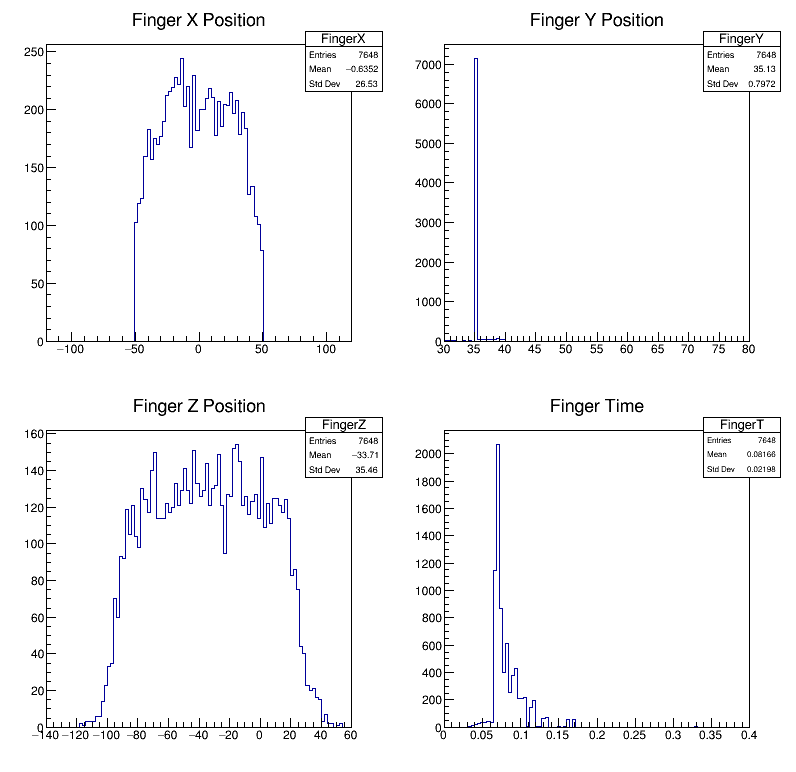

In [5]:
c1.Draw()

In [6]:
c2 = root.TCanvas("c2","c2",800,800)
c2.Divide(2,2,0.01,0.01,0)

c2.cd(1)
hPrimE.Draw()
c2.cd(2)
hPrimTh.Draw()
c2.cd(3)
hPrimPh.Draw()
c2.cd(4)
hPrimPdg.Draw()

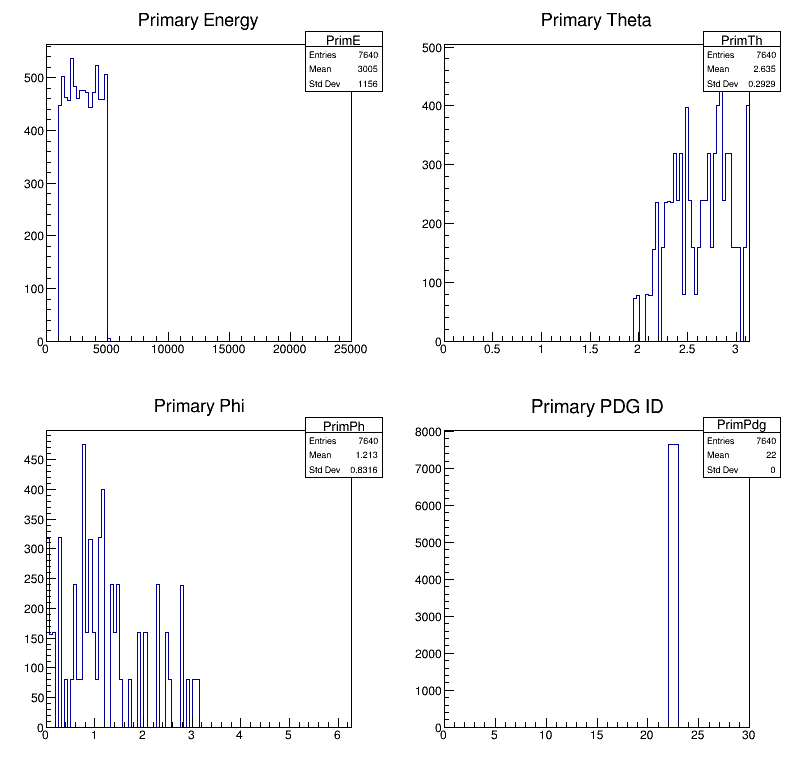

In [7]:
c2.Draw()

In [8]:
c3 = root.TCanvas("c2","c2",800,800)
c3.Divide(2,2,0.01,0.01,0)

c3.cd(1)
hDetectorNhits.Draw()
c3.cd(2)
hDetectorPdg.Draw()
c3.cd(3)
hDetectorID.Draw()
c3.cd(4)
hPMTID.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


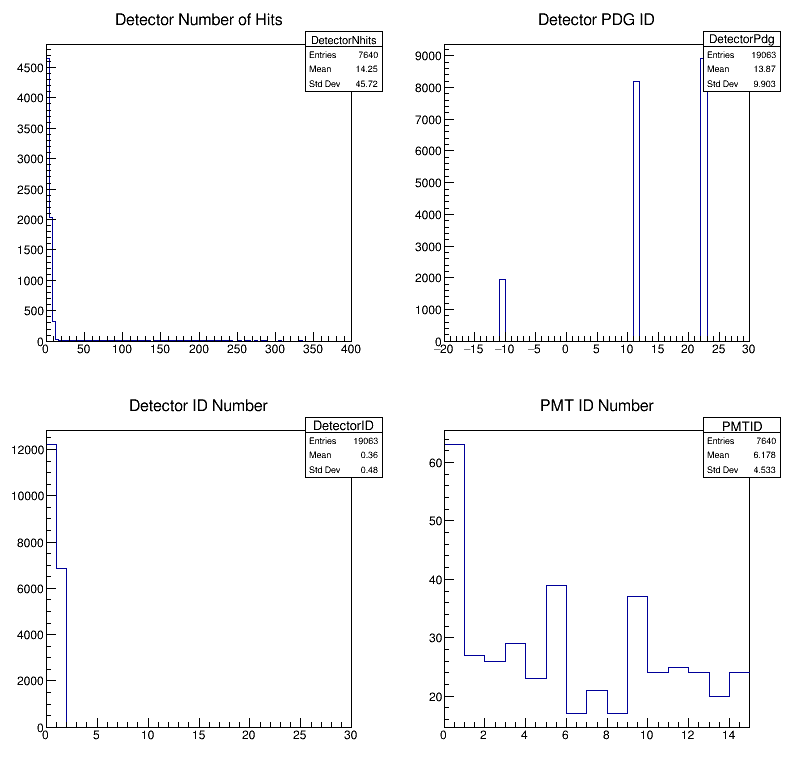

In [9]:
c3.Draw()

In [10]:
c4 = root.TCanvas("c4", "c4", 800,800)
c4.Divide(2,2, 0.01, 0.01, 0)
  
c4.cd(1)
hFingerEd.Draw()
c4.cd(2);
hFingerPMTNphot.Draw()
c4.cd(3)
hAnaBarEd.Draw()
c4.cd(4)
hAnaBarPMTNphot[0].Draw()

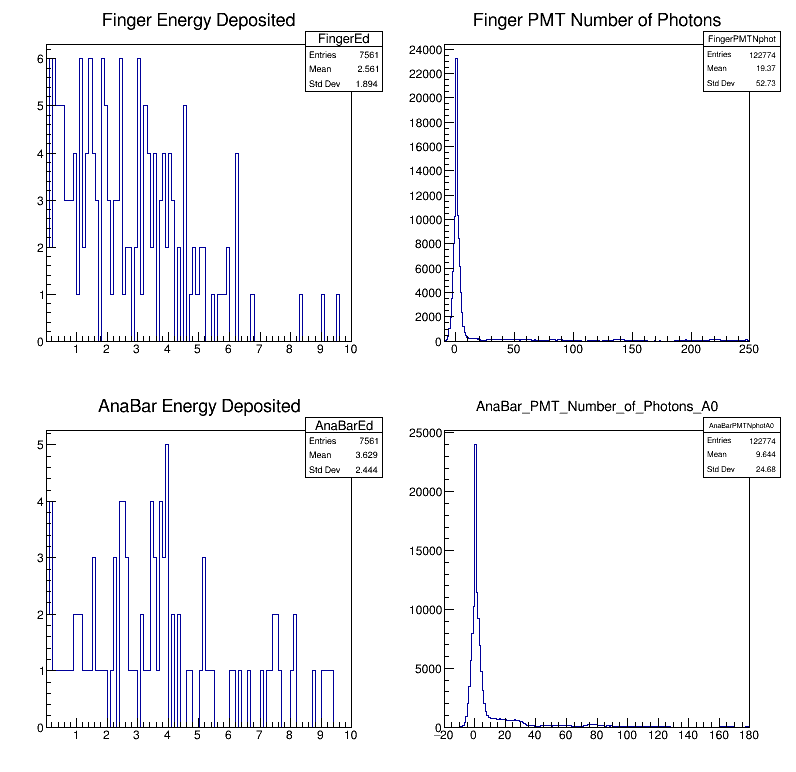

In [11]:
c4.Draw()